# Module import

In [1]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as tf
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image

#Import data

In [2]:
#import shutil

#shutil.rmtree('./CIFAKE')

In [3]:
!git clone https://github.com/jordan-bird/CIFAKE-Real-and-AI-Generated-Synthetic-Images.git CIFAKE

Cloning into 'CIFAKE'...
remote: Enumerating objects: 118688, done.
remote: Counting objects: 100% (118688/118688), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 118688 (delta 118649), reused 118673 (delta 118645), pack-reused 0
Receiving objects: 100% (118688/118688), 39.68 MiB | 42.50 MiB/s, done.
Resolving deltas: 100% (118649/118649), done.
Updating files: 100% (120001/120001), done.


## Prepare train/test data

In [4]:
TRAIN_ANNO_PATH = "train_labels.csv"

In [5]:
train_paths_fake = list(glob('./CIFAKE/DATASET/train/FAKE/*.jpg'))
print(len(train_paths_fake))

df_train_fake = pd.DataFrame(train_paths_fake)
df_train_fake.columns = ['path']
df_train_fake['label'] = 0
df_train_fake.head()

train_paths_real = list(glob('./CIFAKE/DATASET/train/REAL/*.jpg'))
print(len(train_paths_real))

df_train_real = pd.DataFrame(train_paths_real)
df_train_real.columns = ['path']
df_train_real['label'] = 1
df_train_real.head()

df_train = pd.concat((df_train_fake, df_train_real), axis = 0 )
print(df_train.shape)

df_train.to_csv(TRAIN_ANNO_PATH, index=False)

50000
50000
(100000, 2)


In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, target_transform=None):
      self.img_labels = dataframe
      self.img_dir = img_dir
      self.transform = transform
      self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [82]:
training_data = CustomImageDataset(pd.read_csv(TRAIN_ANNO_PATH), "", transform=lambda img: img.type(torch.FloatTensor) / 255)

In [ ]:
# Check if data was loaded without any problems
labels_map = {
    0: "fake",
    1: "real",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze(), cmap="gray")
plt.show()

## Model

In [59]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.sigmoid(self.fc1(x))
        return x

In [52]:
# Initialize the weights of the model
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




### Sanity check

In [79]:
# Assuming train_loader provides batches of input data and corresponding labels
# Use a very small subset of your training data for the sanity check

overfit_subset_size = 50  # Choose a small subset size

# Load a small subset of your training data
overfit_train_loader = DataLoader(training_data, batch_size=16, shuffle=True)
overfit_subset = []
for idx, (inputs, labels) in enumerate(overfit_train_loader):
    overfit_subset.append((inputs, labels))
    if idx + 1 >= overfit_subset_size:
        break

# Unpack inputs and labels from the subset
overfit_inputs, overfit_labels = zip(*overfit_subset)
overfit_inputs = torch.cat(overfit_inputs, dim=0)[:overfit_subset_size]  # Concatenate and limit to subset_size
overfit_labels = torch.cat(overfit_labels, dim=0)[:overfit_subset_size]  # Limit to subset_size

# Move data to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
overfit_inputs = overfit_inputs.to(device)
overfit_labels = overfit_labels.to(device)
overfit_model = SimpleCNN()
overfit_model.apply(weights_init)
overfit_model.to(device)

# Define loss function and optimizer
overfit_criterion = nn.CrossEntropyLoss()
overfit_optimizer = optim.Adam(overfit_model.parameters(), lr=0.0001)



Epoch [10/10000], Loss: 0.6882
Epoch [20/10000], Loss: 0.6841
Epoch [30/10000], Loss: 0.6796
Epoch [40/10000], Loss: 0.6744
Epoch [50/10000], Loss: 0.6687
Epoch [60/10000], Loss: 0.6618
Epoch [70/10000], Loss: 0.6533
Epoch [80/10000], Loss: 0.6427
Epoch [90/10000], Loss: 0.6298
Epoch [100/10000], Loss: 0.6151
Epoch [110/10000], Loss: 0.5993
Epoch [120/10000], Loss: 0.5829
Epoch [130/10000], Loss: 0.5669
Epoch [140/10000], Loss: 0.5523
Epoch [150/10000], Loss: 0.5389
Epoch [160/10000], Loss: 0.5265
Epoch [170/10000], Loss: 0.5148
Epoch [180/10000], Loss: 0.5033
Epoch [190/10000], Loss: 0.4919
Epoch [200/10000], Loss: 0.4811
Epoch [210/10000], Loss: 0.4704
Epoch [220/10000], Loss: 0.4599
Epoch [230/10000], Loss: 0.4499
Epoch [240/10000], Loss: 0.4402
Epoch [250/10000], Loss: 0.4309
Epoch [260/10000], Loss: 0.4219
Epoch [270/10000], Loss: 0.4131
Epoch [280/10000], Loss: 0.4047
Epoch [290/10000], Loss: 0.3969
Epoch [300/10000], Loss: 0.3898
Epoch [310/10000], Loss: 0.3831
Epoch [320/10000]

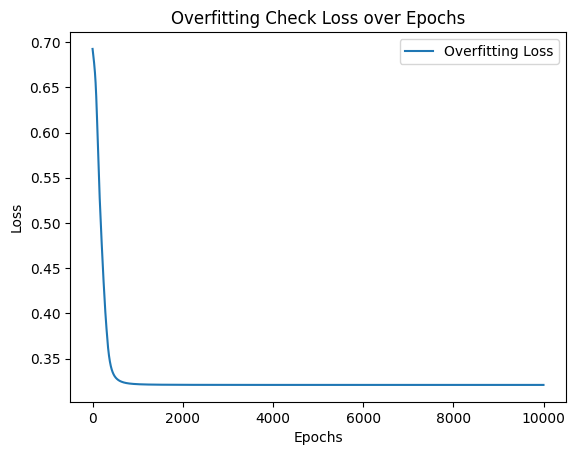

In [80]:
# Train the model on the small subset multiple times (overfitting intentionally)
overfit_epochs = 10000  # Number of epochs for overfitting check

overfit_losses = []  # To track losses during training

for epoch in range(overfit_epochs):
    overfit_optimizer.zero_grad()  # Zero gradients
    overfit_outputs = overfit_model(overfit_inputs)  # Forward pass
    overfit_loss = overfit_criterion(overfit_outputs, overfit_labels)  # Calculate loss
    overfit_loss.backward()  # Backpropagation
    overfit_optimizer.step()  # Update weights

    overfit_losses.append(overfit_loss.item())  # Record the loss

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{overfit_epochs}], Loss: {overfit_loss.item():.4f}")

# Plot the loss curve
import matplotlib.pyplot as plt

plt.plot(range(overfit_epochs), overfit_losses, label='Overfitting Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Overfitting Check Loss over Epochs')
plt.legend()
plt.show()

In [88]:
NUM_EPOCHS = 1000

In [94]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

model = SimpleCNN()
model.apply(weights_init)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
losses = []

model.train()
# Assuming train_loader provides batches of input data and corresponding labels
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0  # Initialize epoch loss
    for i, data in enumerate(train_dataloader, start=0):
        inputs, labels = data  # Get inputs and corresponding labels

        # Move inputs and labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights based on gradients

        # Accumulate epoch loss
        epoch_loss += loss.item()

        # Optionally, print the loss
        if i % 200 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    # Calculate average epoch loss and store it
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    losses.append(avg_epoch_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Average Epoch Loss: {avg_epoch_loss:.4f}")


Epoch [1/1000], Batch [1/1563], Loss: 0.6869
Epoch [1/1000], Batch [201/1563], Loss: 0.6576
Epoch [1/1000], Batch [401/1563], Loss: 0.6559
Epoch [1/1000], Batch [601/1563], Loss: 0.6357
Epoch [1/1000], Batch [801/1563], Loss: 0.6058
Epoch [1/1000], Batch [1001/1563], Loss: 0.5770
Epoch [1/1000], Batch [1201/1563], Loss: 0.5309
Epoch [1/1000], Batch [1401/1563], Loss: 0.5329
Epoch [1/1000], Average Epoch Loss: 0.6101
Epoch [2/1000], Batch [1/1563], Loss: 0.6036
Epoch [2/1000], Batch [201/1563], Loss: 0.5017
Epoch [2/1000], Batch [401/1563], Loss: 0.5546
Epoch [2/1000], Batch [601/1563], Loss: 0.5372
Epoch [2/1000], Batch [801/1563], Loss: 0.5741
Epoch [2/1000], Batch [1001/1563], Loss: 0.5421
Epoch [2/1000], Batch [1201/1563], Loss: 0.4823
Epoch [2/1000], Batch [1401/1563], Loss: 0.5292
Epoch [3/1000], Batch [1/1563], Loss: 0.5380
Epoch [3/1000], Batch [201/1563], Loss: 0.5254
Epoch [3/1000], Batch [401/1563], Loss: 0.5561
Epoch [3/1000], Batch [601/1563], Loss: 0.4881
Epoch [3/1000], B

In [1]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.plot(range(1, 20 + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


NameError: ignored